In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense,BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
train_dir = "/content/drive/MyDrive/segmented/Train_mask"
validation_dir = "/content/drive/MyDrive/segmented/Val_mask"
test_dir= "/content/drive/MyDrive/segmented/Test_mask"


In [ ]:
img_size = (256, 256)
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)


In [ ]:

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
)
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 1058 images belonging to 2 classes.
Found 381 images belonging to 2 classes.


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Corona Virus
1 : Normal


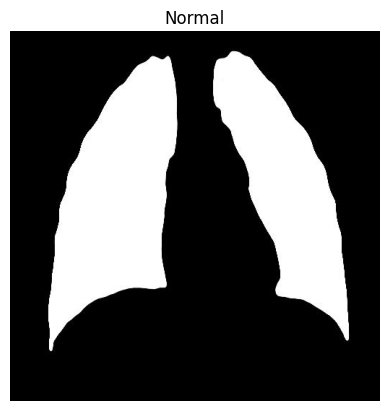

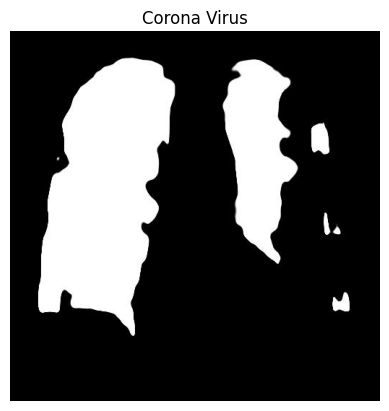

In [ ]:
import os
import random
def plot_sample_images(directory, label):
    class_labels = ['Normal', 'Corona Virus']
    class_dir = os.path.join(directory, class_labels[label])
    image_files = os.listdir(class_dir)
    random_image = random.choice(image_files)
    img_path = os.path.join(class_dir, random_image)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(class_labels[label])
    plt.axis('off')
    plt.show()

plot_sample_images(test_dir, 0) # Normal
plot_sample_images(test_dir, 1) # COVID

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))

for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
x=base_model.get_layer(index=-1).output
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
x=Dense(1,activation='sigmoid')(x)

model=Model(base_model.input,x)

model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(train_generator,epochs=5,validation_data=validation_generator)

Epoch 1/5
34/34 [==============================] - 356s 10s/step - loss: 0.1849 - accuracy: 0.9244 - val_loss: 0.1008 - val_accuracy: 0.9554
Epoch 2/5
34/34 [==============================] - 29s 854ms/step - loss: 0.1167 - accuracy: 0.9509 - val_loss: 0.4744 - val_accuracy: 0.8609
Epoch 3/5
34/34 [==============================] - 30s 890ms/step - loss: 0.0973 - accuracy: 0.9660 - val_loss: 0.1688 - val_accuracy: 0.9449
Epoch 4/5
34/34 [==============================] - 29s 862ms/step - loss: 0.0823 - accuracy: 0.9745 - val_loss: 1.0734 - val_accuracy: 0.6509
Epoch 5/5
34/34 [==============================] - 29s 870ms/step - loss: 0.0744 - accuracy: 0.9773 - val_loss: 0.0528 - val_accuracy: 0.9816


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
data_path_test=test_dir
test_generator = test_datagen.flow_from_directory(
    data_path_test,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary'
)

# Evaluate the model on the test set
results = model.evaluate(test_generator)

print("Test Loss:",results[0])
print("Test Accuracy:",results[1])

Found 260 images belonging to 2 classes.
9/9 [==============================] - 2s 223ms/step - loss: 0.0892 - accuracy: 0.9769
Test Loss: 0.08921506255865097
Test Accuracy: 0.9769230484962463


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
predictions = model.predict(test_generator)
predictions=(predictions>0.5).astype(int)
y_true = test_generator.classes
print(classification_report(y_true,predictions))

9/9 [==============================] - 3s 299ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       130
           1       0.99      0.96      0.98       130

    accuracy                           0.98       260
   macro avg       0.98      0.98      0.98       260
weighted avg       0.98      0.98      0.98       260



9/9 [==============================] - 2s 194ms/step


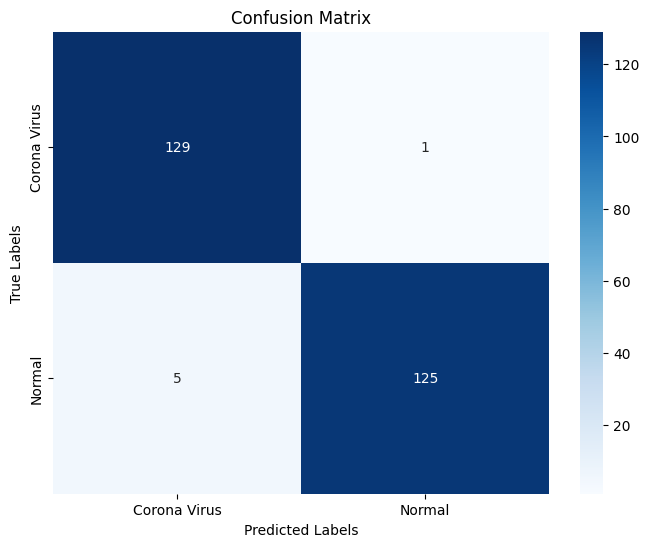

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels
true_labels = test_generator.classes

# Predict the labels using the model
predictions = model.predict(test_generator)

predictions=(predictions>0.5).astype(int)

conf_matrix = confusion_matrix(true_labels,predictions)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()